# Apr 14th, 2022 (carto fixed + some supp)

**Motivation**: This includes error bars, and a function that plots carto for individual nodes  <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
_fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
set_style()

## Fig dir

In [2]:
fig_kws = {
    'transparent': True,
    'bbox_inches': 'tight',
}
fig_dir = pjoin(_fig_dir, 'paper')
os.makedirs(fig_dir, exist_ok=True)

## Prepare

In [3]:
mice = Mice(128)
mice.setup_func_data('rest')

_BOLD = 'BOLD'
_CA = r'Ca$^{2\!\!+}$'
mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {_CA: mako(0.6), _BOLD: rocket(0.6)}

num_k, perc = 5, 10
props_base = {
    'perc': f'p{perc}-sample',
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bold = {'mode': 'bold-lite', **props_base}

In [4]:
gr_ca = Group(**props_ca).fit_group()
gr_bold = Group(**props_bold).fit_group()

remove = [
    n for n, lbl in gr_ca.n2l.items()
    if lbl not in gr_bold.n2l.values()
]
include = np.delete(np.arange(len(gr_ca.n2l)), remove)

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi[:, include],
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

## Carto

In [5]:
affil, affil_included = gr_ca.node_affiliations()
selected = ['Prefrontal', 'Somatomotor', 'Visual', 'Medial']

In [6]:
gr_ca.anim_deg = bn.nanmean(bn.nanmean(gr_ca.run_deg, 2), 1)
gr_bold.anim_deg = bn.nanmean(bn.nanmean(gr_bold.run_deg, 2), 1)

gr_ca.grp_deg = bn.nanmean(bn.nanmean(bn.nanmean(gr_ca.run_deg, 2), 1), 0)
gr_bold.grp_deg = bn.nanmean(bn.nanmean(bn.nanmean(gr_bold.run_deg, 2), 1), 0)

### Anim

In [7]:
dlist = []
for i in range(10):
    dlist.append({
        'mode': [_CA] * len(affil_included),
        'subject': [i + 1] * len(affil_included),
        'Affiliation': affil_included,
        'Entropy': gr_ca.anim_h[i],
        'Degree': gr_ca.anim_deg[i],
    })
    dlist.append({
        'mode': [_BOLD] * len(affil_included),
        'subject': [i + 1] * len(affil_included),
        'Affiliation': affil_included,
        'Entropy': gr_bold.anim_h[i],
        'Degree': gr_bold.anim_deg[i],
    })
df = pd.DataFrame(merge_dicts(dlist))

In [8]:
vlines = [(0.15 * np.log(1 / 0.15) + 0.85 * np.log(1 / 0.85)) / np.log(5)]
vlines += [np.log(i) / np.log(5) for i in range(2, 5)]
hlines = [np.nanquantile(np.concatenate([gr_bold.anim_deg, gr_ca.anim_deg]), q) for q in [0.50, 0.75]]
vlines, hlines

(
    [
        0.26264392340968856,
        0.43067655807339306,
        0.6826061944859854,
        0.8613531161467861
    ],
    [16.0, 22.055555555555557]
)

In [9]:
save_dir = pjoin(fig_dir, 'carto')
os.makedirs(save_dir, exist_ok=True)
save_dir

'/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper/carto'

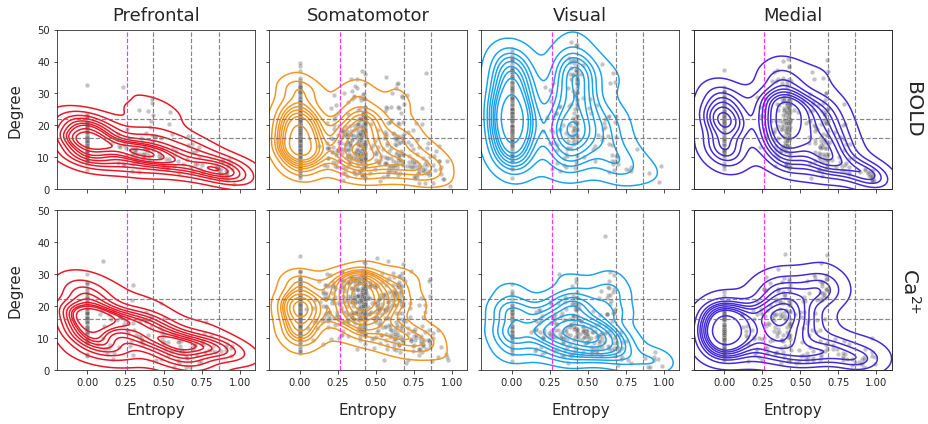

In [10]:
fig, axes = create_figure(2, len(selected), (13, 6), 'all', 'all')

for ax in axes.flat:
    for i, x in enumerate(vlines):
        ax.axvline(x, color='magenta' if i == 0 else 'dimgrey', ls='--', lw=1.2, alpha=0.8)
    for y in hlines:
        ax.axhline(y, color='dimgrey', ls='--', lw=1.2, alpha=0.8)

for i, af in enumerate(selected):
    for ax, (mode, c) in zip(axes[:, i].flat, sorted(pal.items())):
        _df = df.loc[
            (df['mode'] == mode) &
            (df['Affiliation'] == af)
        ]
        sns.scatterplot(
            data=_df,
            x='Entropy',
            y='Degree',
            color='dimgrey',
            s=20,
            alpha=0.4,
            ax=ax,
        )
        sns.kdeplot(
            data=_df,
            x='Entropy',
            y='Degree',
            color=affil['colors'][af],
            ax=ax,
        )
        if mode == _BOLD:
            ax.set_title(af, fontsize=18, y=1.02)
        else:
            ax.set_xlabel('Entropy', fontsize=15, labelpad=15)
        if i == len(selected) - 1:
            axtw = ax.twinx()
            axtw.set_ylabel(mode, fontsize=20, labelpad=30, rotation=-90)
            axtw.set_yticks([])
        elif i == 0:
            ax.set_ylabel('Degree', fontsize=15, labelpad=15)
ax.set_ylim((0, 50))
ax.set_xlim((-0.2, 1.1))

name = 's-carto-density'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), **fig_kws)

plt.show()

In [11]:
num = 20
bins = np.linspace(-1 / num, 1.0, num + 2)
xs = (bins[1:] + bins[:-1]) / 2
xs[0] = 0

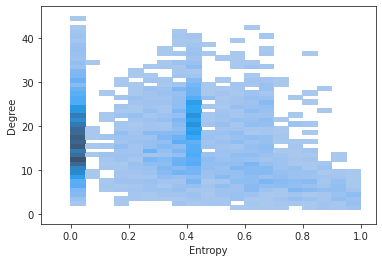

In [12]:
sns.histplot(
    data=df,
    x='Entropy',
    y='Degree',
    bins=[bins, np.linspace(0, 45, 46)],
)
plt.show()

### Group

In [13]:
dlist = []
for mode, _gr in {_BOLD: gr_bold, _CA: gr_ca}.items():
    dlist.append({
        'mode': [mode] * len(affil_included),
        'node': range(len(affil_included)),
        'Affiliation': affil_included,
        'Entropy': _gr.grp_h,
        'Degree': _gr.grp_deg,
    })
df = pd.DataFrame(merge_dicts(dlist))

In [14]:
vlines = [(0.15 * np.log(1 / 0.15) + 0.85 * np.log(1 / 0.85)) / np.log(5)]
vlines += [np.log(i) / np.log(5) for i in range(2, 5)]
hlines = [np.nanquantile(np.concatenate([gr_bold.grp_deg, gr_ca.grp_deg]), q) for q in [0.50, 0.75]]
vlines, hlines

(
    [
        0.26264392340968856,
        0.43067655807339306,
        0.6826061944859854,
        0.8613531161467861
    ],
    [15.837499999999999, 21.458333333333336]
)

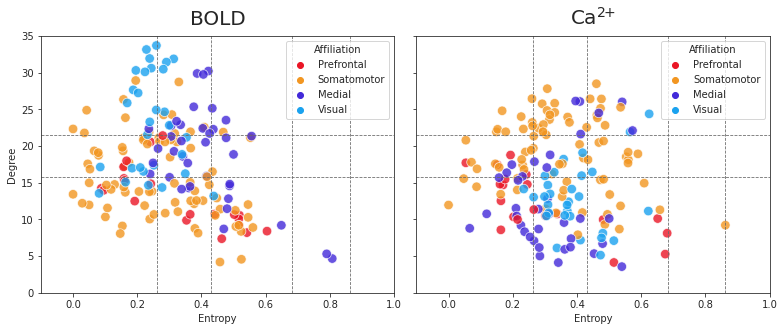

In [15]:
fig, axes = create_figure(1, 2, (11, 4.7), 'all', 'all')
for ax, (mode, c) in zip(axes.flat, sorted(pal.items())):
    for x in vlines:
        ax.axvline(x, color='dimgrey', ls='--', lw=0.8)
    for y in hlines:
        ax.axhline(y, color='dimgrey', ls='--', lw=0.8)
        
    _df = df.loc[
        (df['mode'] == mode) &
        (~df['Affiliation'].isin(['Auditory', 'Lateral']))
    ]
    sns.scatterplot(
        data=_df,
        x='Entropy',
        y='Degree',
        hue='Affiliation',
        palette=affil['colors'],
        s=90,
        alpha=0.8,
        ax=ax,
    )
    ax.set_title(mode, fontsize=20, y=1.02)
ax.set_xlim((-0.1, 1.))
ax.set_ylim((0, 35))

plt.show()

In [16]:
f = 'parcel2d-flat_10um.nii.gz'
f = pjoin(mice.cfg.parcel_dir, f)
parcel_flat = ants.image_read(f, pixeltype='unsigned int')
parcel_flat = parcel_flat.numpy()

f = 'parcel2d-top_10um.nii.gz'
f = pjoin(mice.cfg.parcel_dir, f)
parcel_top = ants.image_read(f, pixeltype='unsigned int')
parcel_top = parcel_top.numpy()

parcel_tr = gr_ca.trim2d({
    'top': np.expand_dims(parcel_top, 0),
    'flat': np.expand_dims(parcel_flat, 0),
})

In [17]:
regions_l = {
    n: mice.parcel.encode(lbl) for lbl, n in gr_ca.l2n.items() if
    (int(lbl.split('-')[0]) == 1 and int(lbl.split('-')[2]) == 0)
}
regions_r = {
    n: mice.parcel.encode(lbl) for lbl, n in gr_ca.l2n.items() if
    (int(lbl.split('-')[0]) == 2 and int(lbl.split('-')[2]) == 0)
}
len(regions_l), len(regions_r)

(82, 82)

In [18]:
len(df['node'].unique())

174

In [19]:
82 * 2

164

In [20]:
figs, sups = [], []
num = 4
for b in tqdm(range(int(np.ceil(len(regions_l) / num)))):
    nrows = min(num, len(regions_l) - b * num)
    fig, axes = create_figure(
        nrows=nrows,
        ncols=6,
        figsize=(13, 2 * nrows),
        sharex='col',
        width_ratios=[1, 1, 0.6, 0.6, 1, 1],
        tight_layout=False,
    )
    for i in range(nrows):
        nl, reg_l = list(regions_l.items())[b * num + i]
        nr, reg_r = list(regions_r.items())[b * num + i]

        ax = axes[i, 2]
        ax.imshow(mwh(parcel_tr['top'] == 0, parcel_tr['top']), cmap='Greys_r')
        x2p = np.zeros(parcel_tr['proj-top'][0].shape)
        x2p[parcel_tr['proj-top'][0] == reg_l] = 0.8
        ax.imshow(mwh(x2p == 0, x2p), cmap='Reds', vmin=0, vmax=1)
        ax.set_title(f"Node = {nl}", fontsize=9)
        remove_ticks(ax)

        ax = axes[i, 3]
        ax.imshow(mwh(parcel_tr['top'] == 0, parcel_tr['top']), cmap='Greys_r')
        x2p = np.zeros(parcel_tr['proj-top'][0].shape)
        x2p[parcel_tr['proj-top'][0] == reg_r] = 0.8
        ax.imshow(mwh(x2p == 0, x2p), cmap='Reds', vmin=0, vmax=1)
        ax.set_title(f"Node = {nr}", fontsize=9)
        remove_ticks(ax)

        for ax, (mode, c) in zip(axes[i, :2], sorted(pal.items())):
            for x in vlines:
                ax.axvline(x, color='dimgrey', ls='--', lw=0.8)
            for y in hlines:
                ax.axhline(y, color='dimgrey', ls='--', lw=0.8)

            _df = df.loc[df['mode'] == mode]
            sns.scatterplot(
                data=_df,
                x='Entropy',
                y='Degree',
                color='dimgrey',
                s=20,
                alpha=0.7,
                ax=ax,
            )
            _ent, _deg = _df.loc[_df['node'] == nl, ['Entropy', 'Degree']].values.flat
            sns.scatterplot(
                x=[_ent],
                y=[_deg],
                color='r',
                s=60,
                alpha=0.9,
                ax=ax,
            )
            ax.annotate(
                text=mode,
                xy=(0.95, 32.5),
                fontsize=9,
                ha='right',
                va='top',
                color='k',
                bbox={'boxstyle': 'round,pad=0.3', 'fc': 'none', 'ec': 'k', 'lw': '.5'},
            )
            msg = f"ent, deg = ({_ent:0.2f}, {_deg:0.2f})"
            ax.set_title(msg, fontsize=8)
            ax.set_xlim((-0.1, 1.))
            ax.set_ylim((0, 35))

            ax.set_xlabel('Entropy', fontsize=9)
            if mode == _BOLD:
                ax.set_ylabel('Degree', fontsize=9)
            else:
                ax.set_ylabel('')
                ax.set_yticklabels([])


        for ax, (mode, c) in zip(axes[i, -2:], sorted(pal.items())):
            for x in vlines:
                ax.axvline(x, color='dimgrey', ls='--', lw=0.8)
            for y in hlines:
                ax.axhline(y, color='dimgrey', ls='--', lw=0.8)

            _df = df.loc[df['mode'] == mode]
            sns.scatterplot(
                data=_df,
                x='Entropy',
                y='Degree',
                color='dimgrey',
                s=20,
                alpha=0.7,
                ax=ax,
            )
            _ent, _deg = _df.loc[_df['node'] == nr, ['Entropy', 'Degree']].values.flat
            sns.scatterplot(
                x=[_ent],
                y=[_deg],
                color='r',
                s=60,
                alpha=0.9,
                ax=ax,
            )
            ax.annotate(
                text=mode,
                xy=(0.95, 32.5),
                fontsize=9,
                ha='right',
                va='top',
                color='k',
                bbox={'boxstyle': 'round,pad=0.3', 'fc': 'none', 'ec': 'k', 'lw': '.5'},
            )
            msg = f"ent, deg = ({_ent:0.2f}, {_deg:0.2f})"
            ax.set_title(msg, fontsize=8)
            ax.set_xlim((-0.1, 1.))
            ax.set_ylim((0, 35))

            ax.set_xlabel('Entropy', fontsize=9)
            ax.set_ylabel('')
            ax.set_yticklabels([])
            
    figs.append(fig)
    sups.append(None)
    plt.close()

  0%|          | 0/21 [00:00<?, ?it/s]

In [21]:
save_dir = pjoin(fig_dir, 'carto')
os.makedirs(save_dir, exist_ok=True)
save_dir

'/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper/carto'

In [22]:
save_fig(
    fig=figs,
    sup=sups,
    save_file=pjoin(save_dir, 'nodes_all.pdf'),
    multi=True,
)

### Error bars

<AxesSubplot:ylabel='Count'>

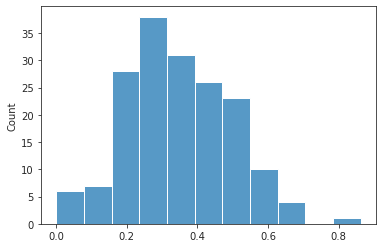

In [23]:
h = bn.nanmean(bn.nanmean(gr_ca.run_pi_prune, 2), 1)
h = sp_stats.entropy(h, axis=-2) / np.log(5)
h = bn.nanmean(h, 0)
sns.histplot(h)

<AxesSubplot:ylabel='Count'>

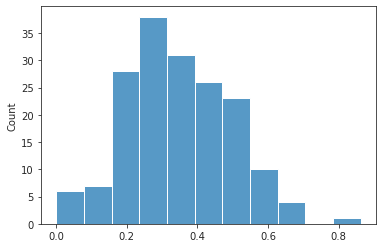

In [24]:
sns.histplot(bn.nanmean(gr_ca.anim_h, 0))

In [25]:
boot = bootstrap(
    x=gr_bold.run_pi_prune,
    n_resamples=int(1e4),
    dims={f'i{i}': gr_bold.run_pi_prune.shape[i] for i in range(3)},
)
boot = bn.nanmean(bn.nanmean(boot, 3), 2)
boot = sp_stats.entropy(boot, axis=-2) / np.log(5)
boot = bn.nanmean(boot, 1)
se_hb = np.nanstd(boot, ddof=1, axis=0)

boot = bootstrap(
    x=gr_ca.run_pi_prune,
    n_resamples=int(1e4),
    dims={f'i{i}': gr_ca.run_pi_prune.shape[i] for i in range(3)},
)
boot = bn.nanmean(bn.nanmean(boot, 3), 2)
boot = sp_stats.entropy(boot, axis=-2) / np.log(5)
boot = bn.nanmean(boot, 1)
se_hc = np.nanstd(boot, ddof=1, axis=0)


boot = bootstrap(
    x=gr_bold.run_deg,
    n_resamples=int(1e4),
    dims={f'i{i}': gr_bold.run_deg.shape[i] for i in range(3)},
)
boot = bn.nanmean(bn.nanmean(bn.nanmean(boot, 3), 2), 1)
se_db = np.nanstd(boot, ddof=1, axis=0)

boot = bootstrap(
    x=gr_ca.run_deg,
    n_resamples=int(1e4),
    dims={f'i{i}': gr_ca.run_deg.shape[i] for i in range(3)},
)
boot = bn.nanmean(bn.nanmean(bn.nanmean(boot, 3), 2), 1)
se_dc = np.nanstd(boot, ddof=1, axis=0)

In [26]:
ci, dof = 0.95, 9
whis = np.round((1 + ci) / 2, 5)
tval = sp_stats.t.ppf(whis, dof)

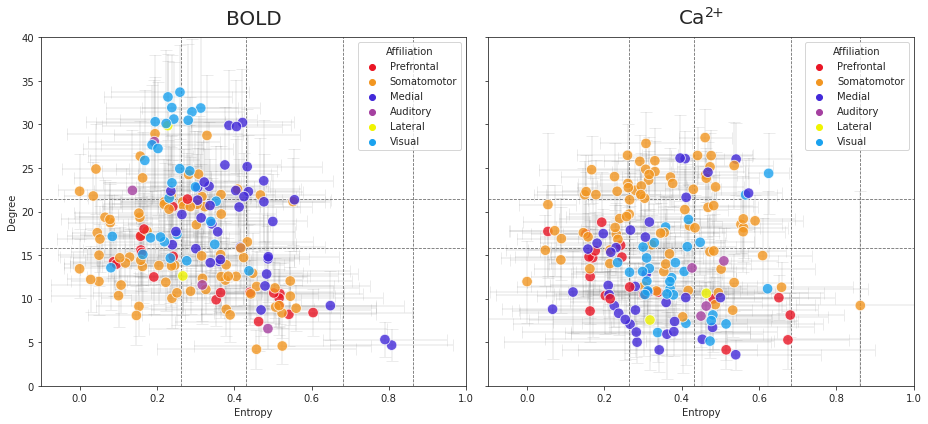

In [29]:
fig, axes = create_figure(1, 2, (13, 6), 'all', 'all')
for ax, (mode, c) in zip(axes.flat, sorted(pal.items())):
    for x in vlines:
        ax.axvline(x, color='dimgrey', ls='--', lw=0.8, zorder=0)
    for y in hlines:
        ax.axhline(y, color='dimgrey', ls='--', lw=0.8, zorder=0)
        
    _df = df.loc[df['mode'] == mode]#) &
#        (~df['Affiliation'].isin(['Auditory', 'Lateral']))
 #   ]
    sns.scatterplot(
        data=_df,
        x='Entropy',
        y='Degree',
        hue='Affiliation',
        palette=affil['colors'],
        s=110,
        alpha=0.8,
        ax=ax,
    )
    ax.set_title(mode, fontsize=20, y=1.02)
    
    ax.errorbar(
        x=_df['Entropy'].values,
        y=_df['Degree'].values,
        xerr=tval * (se_hc if mode == _CA else se_hb),
        yerr=tval * (se_dc if mode == _CA else se_db),
        color='dimgrey',
        errorevery=1,
        capsize=6,
        alpha=0.12,
        ls='none',
        zorder=0,
    )
    
ax.set_xlim((-0.1, 1.))
ax.set_ylim((0, 40))

name = 'carto-group'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), **fig_kws)

plt.show()

(0.0, 35.0)

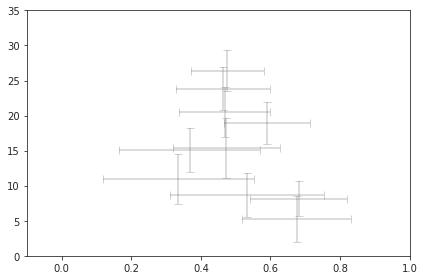

In [31]:
s_ = slice(25, 35)

fig, ax =create_figure()
ax.errorbar(
    x=_df['Entropy'].values[s_],
    y=_df['Degree'].values[s_],
    xerr=(tval * (se_hc if mode == _CA else se_hb))[s_],
    yerr=(tval * (se_dc if mode == _CA else se_db))[s_],
    color='dimgrey',
    errorevery=1,
    capsize=4,
    alpha=0.3,
    ls='none',
    zorder=0,
)
ax.set_xlim((-0.1, 1.))
ax.set_ylim((0, 35))

<AxesSubplot:>

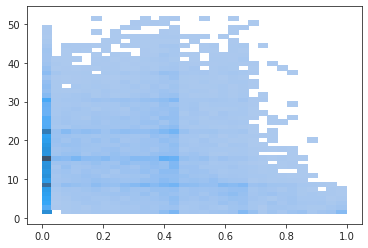

In [40]:
# good = np.logical_and(gr_ca.run_deg.nonzero(), gr_ca.run_h.nonzero())

sns.histplot(y=gr_ca.run_deg.flat, x=gr_ca.run_h.flat)

<AxesSubplot:>

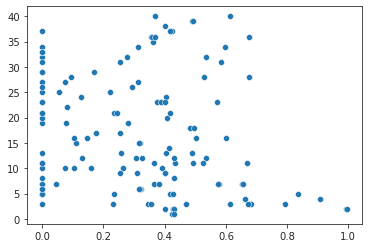

In [41]:
sns.scatterplot(y=gr_ca.run_deg[0, 0, 0], x=gr_ca.run_h[0, 0, 0])

In [46]:
h = sp_stats.entropy(gr_ca.run_pi, axis=-2) / np.log(5)

<AxesSubplot:>

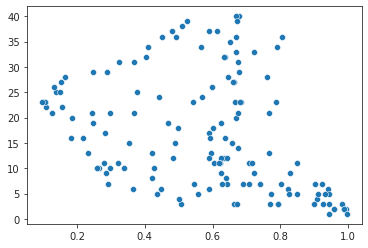

In [47]:
sns.scatterplot(
    y=gr_ca.run_deg[0, 0, 0],
    x=h[0, 0, 0,],
)

<AxesSubplot:>

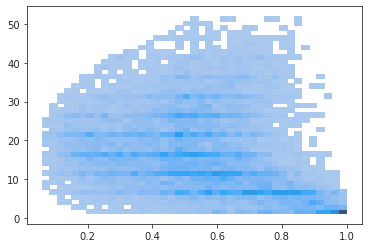

In [49]:
sns.histplot(
    y=gr_ca.run_deg.flat,
    x=h.flat,
)

In [53]:
gr_ca.run_pi.shape

(10, 3, 4, 5, 174)

In [63]:
cut = cut_data(
    data=gr_ca.run_pi.reshape(-1, 5, 174),
    bins=np.linspace(0.2, 1.0, 5),
    oc_only=True,
)[0].reshape(10, 3, 4, 5, -1)
cut_avg = bn.nanmean(bn.nanmean(bn.nanmean(cut, 2), 1), 0)
cut.shape, cut_avg.shape

((10, 3, 4, 5, 4), (5, 4))

(0.0, 50.0)

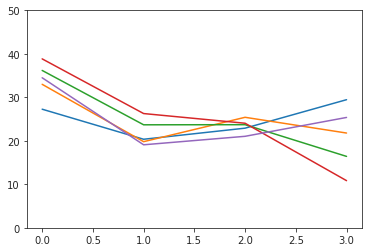

In [68]:
plt.plot(cut_avg.T)
plt.ylim(0, 50)

In [10]:
x = np.load(pjoin(gr_ca.path, 'run_pi.npy'))
x.shape

(10, 3, 4, 1000, 5, 174)

In [57]:
%%time

boot = bootstrap(
    x=x[0,0,0],
    n_resamples=1000000,
    dims={'seed': 1000},
    est=bn.nanmean,
)
boot.shape

CPU times: user 52min 9s, sys: 29min 26s, total: 1h 21min 35s
Wall time: 1h 21min 36s


(1000000, 5, 174)

(0.0, 1.0)

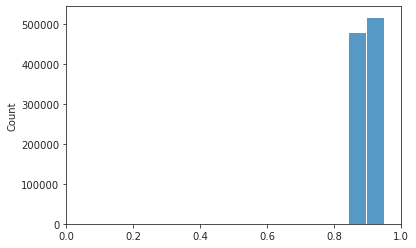

In [58]:
sns.histplot(boot[:, 0, 94], bins=np.linspace(0, 1, 20))
plt.xlim(0, 1)

<AxesSubplot:ylabel='Count'>

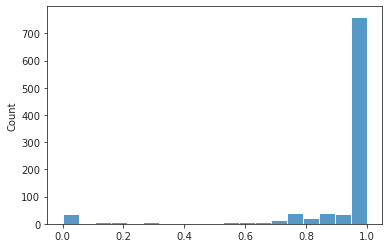

In [59]:
sns.histplot(x[0, 0, 0, :, 0, 94], bins=np.linspace(0, 1, 20))

(0.0, 1.0)

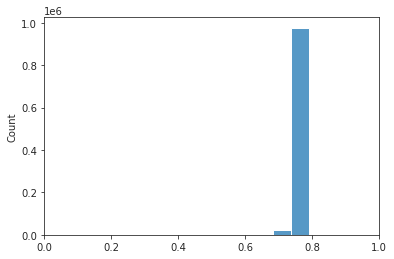

In [60]:
sns.histplot(boot[:, 0, 11], bins=np.linspace(0, 1, 20))
plt.xlim(0, 1)

<AxesSubplot:ylabel='Count'>

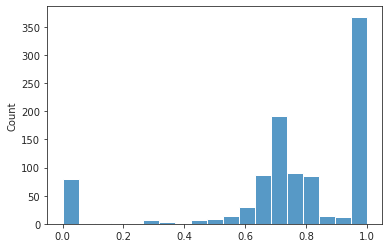

In [61]:
sns.histplot(x[0, 0, 0, :, 0, 11], bins=np.linspace(0, 1, 20))

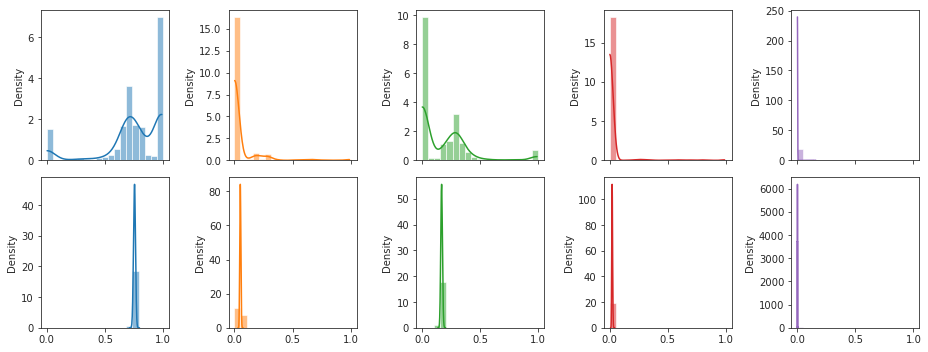

In [62]:
fig, axes = create_figure(2, 5, (13, 5), 'all')
for i in range(5):
    sns.histplot(
        x[0, 0, 0, :, i, 11],
        bins=np.linspace(0, 1, 20),
        color=f'C{i}',
        stat='density',
        kde=True,
        ax=axes[0, i],
    )
    sns.histplot(
        boot[:, i, 11],
        bins=np.linspace(0, 1, 20),
        color=f'C{i}',
        stat='density',
        kde=True,
        ax=axes[1, i],
    )

In [63]:
mu = np.mean(boot[:, :, 11], axis=0)
se = np.nanstd(boot[:, :, 11], ddof=1, axis=0)

mu, se

(
    array([0.75403256, 0.0513314 , 0.16886127, 0.02273502, 0.00303974]),
    array([0.00855958, 0.00474681, 0.00716795, 0.00357442, 0.00020917])
)

In [64]:
tval = sp_stats.t.ppf(0.995, 999)
tval

2.580759637267628

In [65]:
mu - se * tval

array([0.73194234, 0.03908103, 0.15036251, 0.0135103 , 0.00249994])

In [66]:
pi = [0.75403756, 0.05135484, 0.16886941, 0.02269757, 0.00304062]
sum(pi)

1.0

In [67]:
pi = np.array([0.75403756, 0, 0.16886941, 0, 0])
pi /= sum(pi)
pi

array([0.81702445, 0.        , 0.18297555, 0.        , 0.        ])

In [68]:
x[0, 0, 0, :, :, 11].mean(0), mu

(
    array([0.7540318 , 0.05133596, 0.16885728, 0.02273515, 0.00303981]),
    array([0.75403256, 0.0513314 , 0.16886127, 0.02273502, 0.00303974])
)

In [70]:
x[0, 0, 0, :, :, 11][:, 1] = 0
x[0, 0, 0, :, :, 11][:, 3] = 0
x[0, 0, 0, :, :, 11][:, 4] = 0

In [72]:
x /= np.nansum(x, axis=-2, keepdims=True)

In [73]:
x[0, 0, 0, :, :, 11].mean(0)

array([0.80606155, 0.        , 0.19393845, 0.        , 0.        ])